# Load libraries

In [15]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import csv
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
from IPython.display import display
import re
from tqdm.notebook import tqdm
import networkx as nx

# load CSV

In [2]:
# load the country_links.csv file with rownames
country_links = pd.read_csv('country_links.csv', index_col=0)

# Get the page ranges and add it to the df

In [5]:
def get_total_pages(s):
    match = re.search(r'\((?:page )?\d+/(\d+)\)', s)
    if match:
        return int(match.group(1))
    else:
        return 1

def getPageRange(driver, url):
    driver.get(url)
    time.sleep(1)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    # find the id topBlueBarGroupsCatalogLabel and get the content of it
    page_range_div = soup.find(id='topBlueBarGroupsCatalogLabel')
    if page_range_div:
        page_range = page_range_div.get_text()
        return get_total_pages(page_range)
    else:
        return None

def login(driver, url):
    driver.get(url)

    # switch to the iframe
    iframe = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.ID, 'sp_message_iframe_1117340')))
    driver.switch_to.frame(iframe)

    # accept the cookies
    try:
        wait = WebDriverWait(driver, 20)  # increase wait time to 20 seconds
        button = wait.until(EC.presence_of_element_located((By.XPATH, '//button[@title="Accept" and @aria-label="Accept"]')))  # use more specific XPath
        button.click()
    except TimeoutException:
        print("Could not find the Accept button.")

    driver.switch_to.default_content()

    time.sleep(1)
    # click the login button
    driver.find_element(By.ID, 'signIn').click()
    time.sleep(1)
    # enter username
    driver.find_element(By.ID, 'username').send_keys('timo1024')
    # enter password
    driver.find_element(By.ID, 'password').send_keys('StampworldSecure')
    # click the login button
    driver.find_element(By.ID, 'loginBtn').click()
    time.sleep(1)

In [9]:
country_links.reset_index(drop=True, inplace=True)

# make new column for total pages
country_links['total_pages'] = 0

options = Options()
options.headless = False
driver = webdriver.Firefox(options=options)

# login
login(driver, 'https://www.stampworld.com/en/')
time.sleep(1)

for index, row in tqdm(country_links.iterrows(), total=country_links.shape[0], desc="Processing"):
    url = f"https://www.stampworld.com{row['url']}"
    total_pages = getPageRange(driver, url)
    country_links.loc[index, 'total_pages'] = total_pages

driver.quit()

Processing:   0%|          | 0/1179 [00:00<?, ?it/s]

In [11]:
# drop all rows where total_pages is None
country_links.dropna(subset=['total_pages'], inplace=True)

country_links.to_csv('country_links_pages.csv')

# make plots

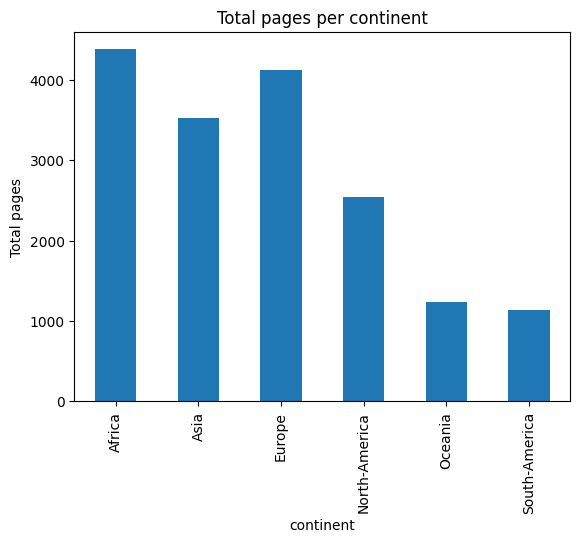

In [12]:
# from country_links make plot with total pages per continent
continent_pages = country_links.groupby('continent').total_pages.sum()
continent_pages.plot(kind='bar')
plt.ylabel('Total pages')
plt.title('Total pages per continent')
plt.show()

In [14]:
country_links

,url,parent_countries,continent,total_pages
0,/en/stamps/Aaland/,['Finland'],Europe,12.0
1,/en/stamps/Aegean-Islands/,"['Italy', 'Italian Occupations', 'Aegean Islan...",Europe,4.0
2,/en/stamps/Calimno/,"['Italy', 'Italian Occupations', 'Aegean Islan...",Europe,1.0
3,/en/stamps/Caso/,"['Italy', 'Italian Occupations', 'Aegean Islan...",Europe,1.0
4,/en/stamps/Castelrosso/,"['Italy', 'Italian Occupations', 'Aegean Islan...",Europe,1.0
...,...,...,...,...
1174,/en/stamps/Nukulaelae/,['Tuvalu'],Oceania,3.0
1175,/en/stamps/Vaitupu/,['Tuvalu'],Oceania,3.0
1176,/en/stamps/Gilbert-and-Ellice-Islands/,['Tuvalu'],Oceania,5.0
1177,/en/stamps/Vanuatu/,['Vanuatu'],Oceania,21.0
